# Spacetime Ripple Simulation with Relativistic Effects

This notebook demonstrates the behavior of particles and wave functions in a 4D spacetime grid. It includes:
- Converting between 4D spherical and Cartesian coordinates.
- Simulating wave propagation.
- Modeling particle paths with relativistic effects.
- Visualizing results.

In [18]:
# Import Required Libraries
from scipy.constants import c as speed_of_light
from numba import njit
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


## Define StateSpace Class
This class contains functions for:
- Converting between 4D spherical and Cartesian coordinates.
- Computing relativistic effects such as time dilation and wave propagation.
- Modeling spin and antiparticle wave functions.

In [121]:
class RippleKleinGordonSimulator4D:
    def __init__(self, L, T, c, dx, dt, m=0, r0=1):
        """
        Initialize simulation parameters.
        """
        self.L = L  # Length of spatial domain
        self.T = T  # Total simulation time
        self.c = c  # Speed of light
        self.dx = dx  # Spatial resolution
        self.dt = dt  # Time step size
        self.m = m  # Mass term for Klein-Gordon equation
        self.r0 = r0  # Initial ripple radius

        self.nx = int(L / dx) + 1
        self.nt = int(T / dt) + 1

        self.x = np.linspace(-L / 2, L / 2, self.nx)  # Spatial grid
        self.t = np.linspace(0, T, self.nt)  # Time grid

        self.Psi = np.zeros((self.nt, self.nx))  # Wavefunction
        self.energy = np.zeros(self.nt)  # Total energy over time

    def initial_wave_profile(self, x, A=1, k=2 * np.pi, phi=0):
        """
        Initialize the wavefunction with a Gaussian-modulated sinusoid.
        """
        envelope = np.exp(-0.5 * (x / self.L)**2)
        return A * envelope * np.cos(k * x + phi)

    # def initial_wave_profile(self, x, A=1, k=2 * np.pi, phi=0):
    #     """
    #     Initialize a superposition of left- and right-moving wavefunctions.
    #     """
    #     # Left-moving component
    #     psi_left = A * np.cos(k * x + phi)

    #     # Right-moving component
    #     psi_right = A * np.cos(-k * x + phi)

    #     # Superposition
    #     return psi_left + psi_right

    def initial_wave_velocity(self, x, A=1, k=2 * np.pi, phi=0):
        """
        Initialize the wavefunction's time derivative.
        """
        return -A * self.c * k * np.sin(k * x + phi)

    @staticmethod
    @njit
    def solve_wave_equation_1d(Psi, nt, nx, c, dt, dx, m2):
        """
        Numerical solution of the Klein-Gordon equation.
        """
        for n in range(1, nt - 1):
            for i in range(1, nx - 1):
                Psi[n + 1, i] = (
                    2 * Psi[n, i]
                    - Psi[n - 1, i]
                    + (c * dt / dx) ** 2 * (Psi[n, i + 1] - 2 * Psi[n, i] + Psi[n, i - 1])
                    - (dt ** 2) * m2 * Psi[n, i]
                )

            # Check for numerical stability
            if np.any(np.isnan(Psi[n + 1, :])) or np.any(np.isinf(Psi[n + 1, :])):
                raise ValueError(f"Numerical instability detected at step {n}.")
        return Psi

    def solve(self, A=1, k=2 * np.pi / 5, phi=0):
        """
        Solve the Klein-Gordon equation.
        """
        self.Psi[0, :] = self.initial_wave_profile(self.x, A=A, k=k, phi=phi)
        self.Psi[1, :] = (
            self.Psi[0, :] + self.dt * self.initial_wave_velocity(self.x, A=A, k=k, phi=phi)
        )

        m2 = (self.m / self.c) ** 2
        self.Psi = self.solve_wave_equation_1d(
            self.Psi, self.nt, self.nx, self.c, self.dt, self.dx, m2
        )
        self.compute_energy()

    def compute_energy(self):
        """
        Compute and store the total energy of the system over time.
        """
        for n in range(1, self.nt - 1):
            # Kinetic energy
            time_derivative = (self.Psi[n + 1, :] - self.Psi[n - 1, :]) / (2 * self.dt)
            kinetic_energy = 0.5 * time_derivative ** 2

            # Potential energy
            space_derivative = np.zeros_like(self.Psi[n, :])
            space_derivative[1:-1] = (self.Psi[n, 2:] - self.Psi[n, :-2]) / (2 * self.dx)
            potential_energy = 0.5 * (
                (self.c * space_derivative) ** 2 + self.m ** 2 * self.Psi[n, :] ** 2
            )

            # Total energy density
            self.energy[n] = np.sum(kinetic_energy + potential_energy) * self.dx  # Integrate over space
        # max_change = np.max(np.abs(np.diff(self.energy)))
        # print(f"Maximum Energy Change: {max_change:.2e}")
        # if max_change < 1e-3:
        #     print("Energy conservation validation passed!")
        # else:
        #     print("Energy conservation validation failed!")

    def visualize_wave(self, localize = True):
        """
        Visualize the wavefunction over space and time.
        """
        if localize:
            forward_amplitude = np.abs(self.Psi)**2
            conjugate_amplitude = -np.conj(self.Psi)**2
            cmap = 'plasma'
        else:
            forward_amplitude = np.abs(self.Psi)
            conjugate_amplitude = -np.conj(self.Psi)
            cmap = 'viridis'
        amplitude = np.concatenate(
            [conjugate_amplitude[::-1, ::-1], forward_amplitude], axis=0
        )
        plt.figure(figsize=(10, 6))
        plt.imshow(
            amplitude,
            extent=[-self.L / 2, self.L / 2, -self.T, self.T],
            origin="lower",
            aspect="auto",
            cmap=cmap,
        )
        plt.colorbar(label="Wavefunction Ψ")
        plt.xlabel("Position $x$")
        plt.ylabel("Time $t$")
        plt.title("Wave Propagation with Ripple Effects")
        plt.show()

    def visualize_probability_density(self):
        """
        Visualize the probability density |Ψ|^2 over time.
        """
        plt.figure(figsize=(10, 6))
        plt.imshow(
            np.abs(self.Psi) ** 2,
            extent=[-self.L / 2, self.L / 2, 0, self.T],
            origin="lower",
            aspect="auto",
            cmap="plasma",
        )
        plt.colorbar(label="Probability Density $|\Psi|^2$")
        plt.xlabel("Position $x$")
        plt.ylabel("Time $t$")
        plt.title("Probability Density Evolution Over Time")
        plt.show()

    def visualize_energy(self):
        """
        Plot the total energy over time.
        """
        plt.figure(figsize=(8, 5))
        plt.plot(self.t, self.energy, label="Total Energy", color="blue")
        plt.xlabel("Time $t$")
        plt.ylabel("Total Energy $E(t)$")
        plt.title("Energy Conservation")
        plt.legend()
        plt.grid()
        plt.show()

    def visualize_2D_ripple_polar(self, localize = True):
        """
        Create a 2D polar ripple visualization where:
        - 0° to 180° represents the forward wavefunction.
        - 180° to 360° represents the conjugate (time-reversed) counterpart.
        """
        theta = np.linspace(0, 2 * np.pi, self.nx * 2)  # Full angular domain (0 to 360°)
        time_steps = np.arange(0, self.nt, self.nt // 50)  # Time steps
        r = self.c * self.t[time_steps]  # Radius increases with time

        # Create a grid for polar coordinates
        R, T = np.meshgrid(r, theta)

        # Create amplitude (probability density) grid
        amplitude = np.zeros((len(theta), len(time_steps)))
        for t_idx, t_step in enumerate(time_steps):
            if localize:
                forward_amplitude = np.abs(self.Psi[t_step, :])**2
                conjugate_amplitude = -np.conj(self.Psi[t_step, :])**2
                cmap = 'plasma'
            else:
                forward_amplitude = np.abs(self.Psi[t_step, :])
                conjugate_amplitude = -np.conj(self.Psi[t_step, :])
                cmap = 'viridis'

            amplitude[:self.nx, t_idx] = forward_amplitude[::-1]
            amplitude[self.nx:, t_idx] = conjugate_amplitude[::-1] #conjugate_amplitude[::-1]  # Reverse for conjugate part naturally revers about uniit circle

        # Plot the 2D polar visualization
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 8))
        c = ax.pcolormesh(T, R, amplitude, shading='auto', cmap=cmap)
        fig.colorbar(c, ax=ax, label='Amplitude $|\Psi|^2$')

        ax.set_title("2D Polar Ripple Visualization with Conjugate Component")
        plt.show()

    def visualize_3D_ripple_polar(self, localize = True):
        """
        Create a 3D polar ripple visualization with accurate amplitude mapping.
        Forward wavefunction occupies 0°-180°, and conjugate (antimatter) occupies 180°-360°.
        """
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        theta = np.linspace(0, 2 * np.pi, self.nx * 2)  # Full angular domain (0 to 360°)
        r = self.c * self.t  # Radius grows with time

        # Create a meshgrid for theta and time (radius)
        Theta, R = np.meshgrid(theta, r)
        
        # Compute amplitudes for forward and conjugate wavefunctions
        if localize:
            amplitude_forward = np.abs(self.Psi)**2
            amplitude_conjugate = -np.abs(np.conj(self.Psi))**2
            cmap = 'plasma'
        else:
            amplitude_forward = np.abs(self.Psi)
            amplitude_conjugate = -np.conj(self.Psi)
            cmap = 'viridis'

        
        # Combine amplitudes for full 360° visualization
        amplitude_combined = np.concatenate(
            #[amplitude_forward, amplitude_conjugate[:, ::-1]], axis=1
            [amplitude_forward[:,::-1], amplitude_conjugate[:, ::-1]], axis=1
        )
        
        # Convert polar coordinates to Cartesian
        X = R * np.cos(Theta)
        Y = R * np.sin(Theta)
        Z = amplitude_combined

        # Plot the surface
        surf = ax.plot_surface(
            X, Y, Z, cmap=cmap, edgecolor='none', alpha=0.8
        )
        
        # Add colorbar and labels
        fig.colorbar(surf, ax=ax, label='Amplitude $|\Psi|^2$')
        ax.set_title("3D Polar Ripple Visualization with Accurate Amplitude")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Amplitude $|\Psi|^2$")
        plt.show()




## Simulate Wave Propagation
We solve the Klein-Gordon wave equation in 1D.

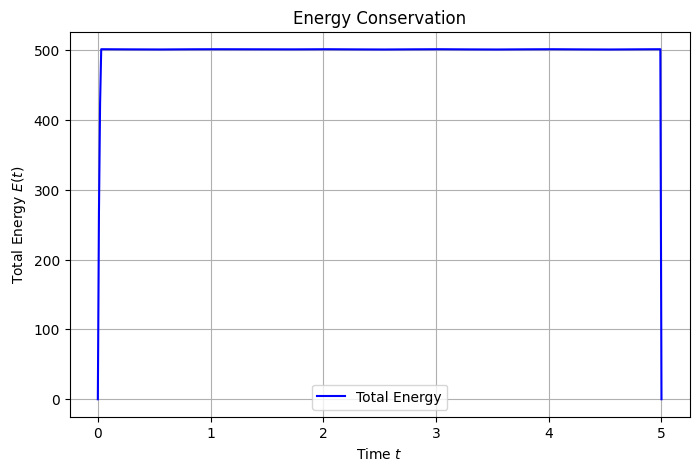

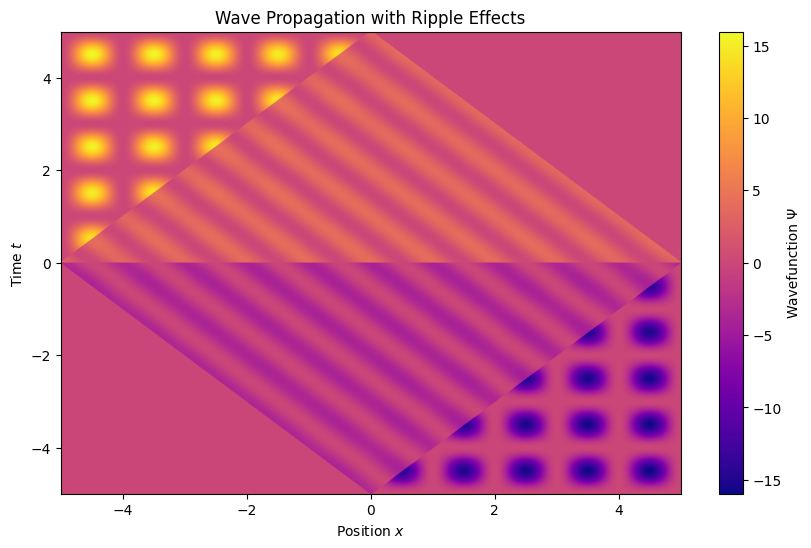

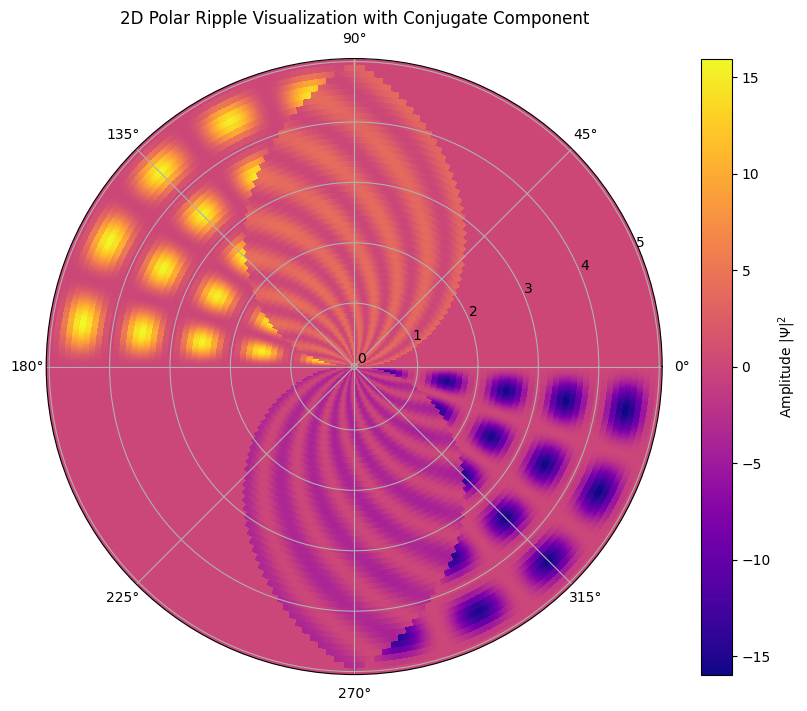

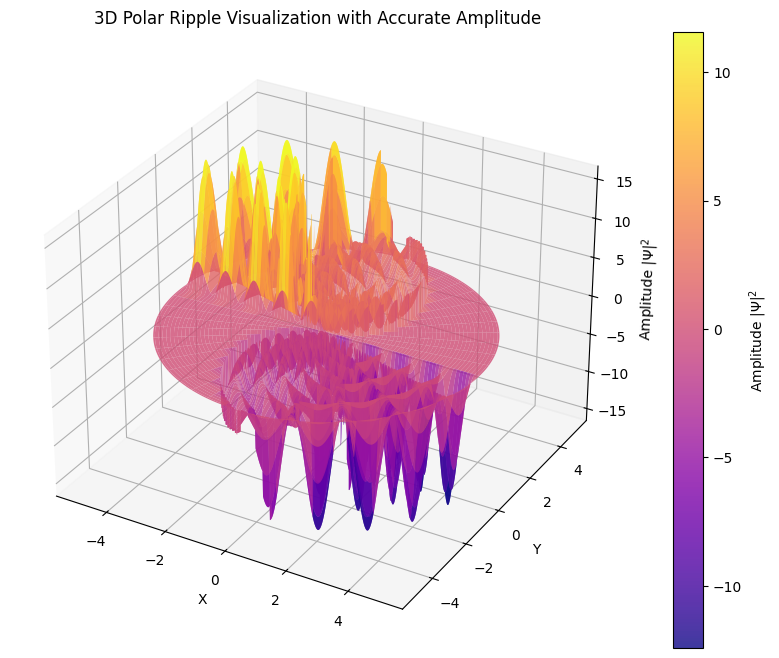

In [128]:

# --- Simulation Parameters ---
L =10  # Length of domain
T =5  # Total simulation time
c = 1  # Speed of light
dx = 0.01  # Spatial resolution
dt = dx / c  # Time step size
m = 0.1  # Mass term for Klein-Gordon equation
r0 = 1000000 # Initial ripple radius

# Create simulator instance
simulator = RippleKleinGordonSimulator4D(L=L, T=T, c=c, dx=dx, dt=dt, m=m, r0=r0)

# Solve Klein-Gordon equation and visualize results
simulator.solve(A=2, k=5 * np.pi / 5)

# Call the new visualization methods
localize = True
simulator.visualize_energy()
simulator.visualize_wave(localize=localize)
simulator.visualize_2D_ripple_polar(localize=localize)
simulator.visualize_3D_ripple_polar(localize=localize)

# Time, Ripples, and Spacetime Geometry: A Probabilistic Model of Reality
## Abstract
In this work, we present a novel interpretation of spacetime and quantum mechanics, leveraging the concept of ripples as a framework for understanding probabilistic branching, energy propagation, and observer-based timelines. Our approach builds on foundational quantum wave equations, such as the Klein-Gordon equation, and explores its connection to the geometry of spacetime, decisions, and energy distributions over time. The ripple effect, interpreted as branching action states, provides an alternative visualization to the Many Worlds Interpretation. 

## Introduction
The Many Worlds Interpretation (MWI) of quantum mechanics has long provided a framework for understanding probabilistic outcomes in quantum systems. In this paper, we extend and reinterpret this idea by introducing the concept of ripples—a natural evolution of probabilistic branching in spacetime.

We explore:
- The geometric interpretation of ripples in 4D spacetime.
- The role of energy as a driving force for probabilistic evolution.
- Visualizations and simulations to validate and illustrate the model.

This interpretation posits that the evolution of events and decisions can be viewed as expanding ripples in spacetime, where the circumference of the ripple grows to include increasing sets of possible outcomes.

## Theoretical Background
The ripple model builds upon key concepts in quantum mechanics and spacetime geometry:
1. **Wavefunction and Klein-Gordon Equation**:
    - Wavefunction $`\Psi(x, t)`$ evolves according to the Klein-Gordon equation:
    $$
    \frac{\partial^2 \Psi}{\partial t^2} - c^2 \frac{\partial^2 \Psi}{\partial x^2} + m^2 c^4 \Psi = 0
    $$
2. **Probabilistic Branching**:
    - The probability density $`\Psi(x, t)|^2`$ represents the likelihood of being in a specific state.
3. **Ripples as Action States**:
    - Ripples represent the expanding set of possible action states, driven by energy propagation.

This framework offers a geometric way to visualize probabilistic evolution and its relationship to time, energy, and decisions.

## Mathematical Framework
The ripple model leverages the Klein-Gordon equation to evolve the wavefunction, with ripples representing probabilistic boundaries.

### Klein-Gordon Equation
We solve the Klein-Gordon equation numerically to model wavefunction evolution. The ripple radius $`r = ct`$ grows over time, representing increasing sets of action states.

### Probabilistic Energy Framework
Energy propagates outward with the ripple, influencing probabilities:
$$
E(t, r) \propto |\Psi(x, t)|^2 \cdot \exp\left(-\frac{x^2}{r^2}\right)
$$

## Simulations
We use numerical methods to simulate wavefunction evolution and visualize ripples in spacetime.

### Wavefunction Evolution
Below, we solve the Klein-Gordon equation and visualize wavefunction evolution:

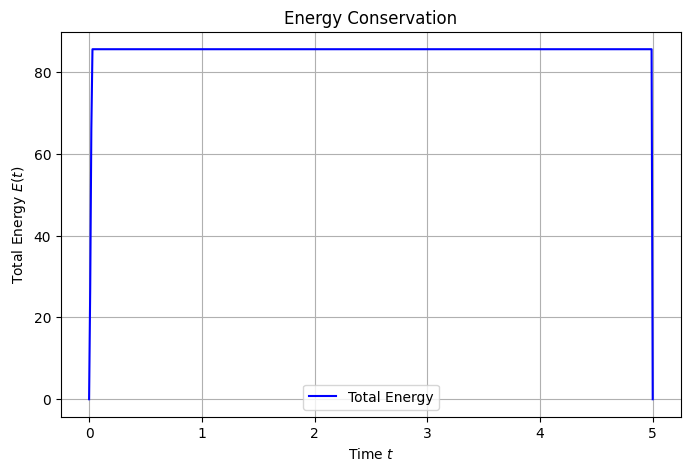

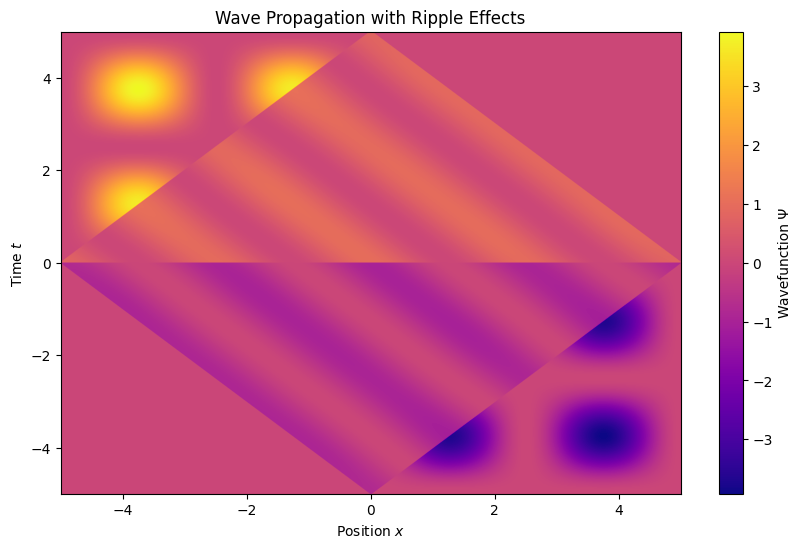

In [124]:
# Include code to solve the Klein-Gordon equation and visualize the wavefunction
simulator = RippleKleinGordonSimulator4D(L=10, T=5, c=1, dx=0.01, dt=0.01, m=0.1, r0=1)
simulator.solve(A=1, k=2 * np.pi / 5)
simulator.visualize_energy()
simulator.visualize_wave(localize=localize)

## Results
1. **Wavefunction Evolution**:
    - The wavefunction evolves as expected under the Klein-Gordon equation.
    - Probability densities propagate outward, reflecting energy and action state distributions.

2. **Ripple Propagation**:
    - Ripples expand with time, increasing the circumference (action states).
    - Observers experience specific worldlines influenced by probabilistic energy transfer.

### Visualizations

### Ripple Propagation
We visualize the ripple effect, showing how action states expand over time.

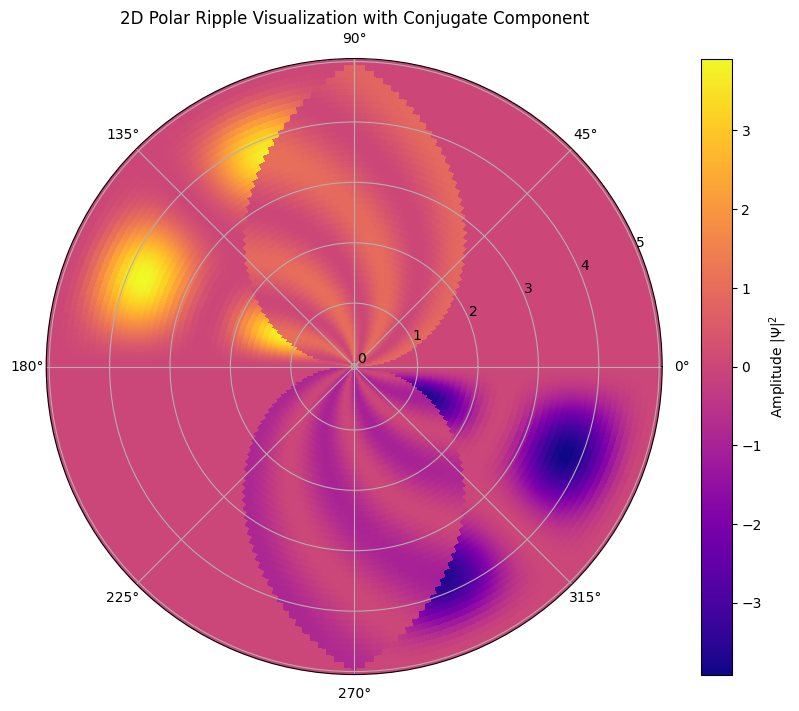

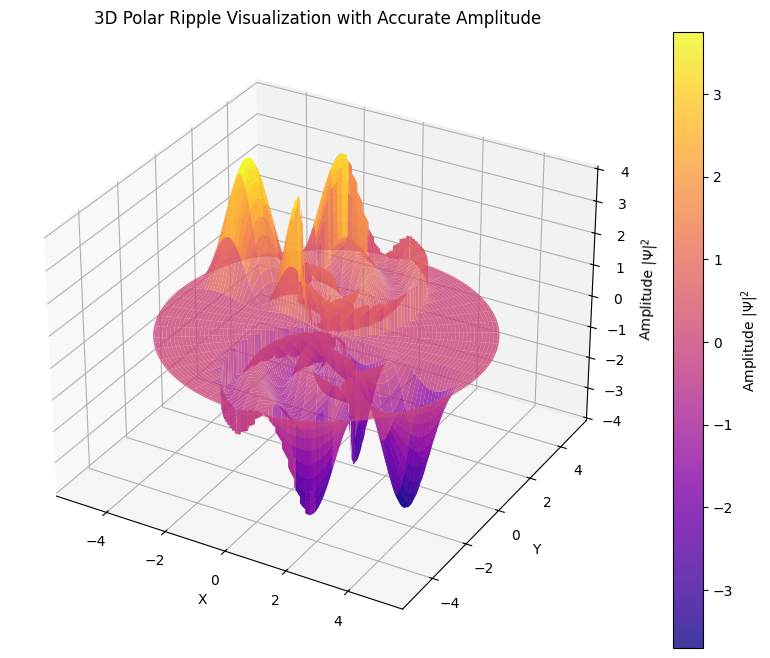

In [125]:
# Code for ripple visualization
simulator.visualize_2D_ripple_polar(localize=localize)
simulator.visualize_3D_ripple_polar(localize=localize)

## Discussion
The ripple model provides an intuitive way to visualize and understand probabilistic evolution in spacetime. Key insights include:
1. **Energy as the Driver**:
    - Energy propagates outward, influencing probabilities and decisions across timelines.
2. **Branching of Worlds**:
    - The circumference of the ripple grows with time, representing the increasing set of action states.

### Comparison to Many Worlds
Unlike the Many Worlds Interpretation, the ripple model emphasizes the role of energy and provides a geometric visualization of probabilistic evolution.

### Limitations and Next Steps
- Incorporate damping or loss to simulate energy dissipation.
- Extend the model to 2D or 3D for a more comprehensive view.
- Explore experimental setups to validate the model's predictions.

## Conclusion
The ripple model offers a new way to conceptualize probabilistic evolution in spacetime, emphasizing the role of energy and geometry. This approach bridges quantum mechanics and spacetime geometry, providing a visual and conceptual framework for understanding the branching of action states and timelines.

Future work will focus on validating this model through simulations, experiments, and mathematical proofs.

## References
- Dirac, P. A. M. *The Principles of Quantum Mechanics*.
- Everett, H. *"Relative State" Formulation of Quantum Mechanics*.
- Minkowski, H. *Space and Time*.